<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных-в-Hadoop" data-toc-modified-id="Загрузка-данных-в-Hadoop-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных в Hadoop</a></span></li><li><span><a href="#Чтение-данных-из-HDFS-в-Spark" data-toc-modified-id="Чтение-данных-из-HDFS-в-Spark-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Чтение данных из HDFS в Spark</a></span></li><li><span><a href="#Аналитика" data-toc-modified-id="Аналитика-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Аналитика</a></span></li></ul></div>

Файловая система ` HDFS ` (Hadoop Distributed File System) существует независимо от файловой системы хоста, работающего как правило, на базе \*nix ОС. Тем не менее, набор команд для управления ` HDFS ` очень похож на стандартный набор командной строки \*nix OS, регламентируемый ` POSIX ` стандартом ( ` ls, mkdir, rm, cp, du, df ` ) и может быть сгруппирован следующим образом:  

- Просмотр файловой структуры:
    - ` hadoop fs -ls , hadoop fs -du, hadoop fs -df`  
 
 
- Копирование файлов:  
    - ` hadoop fs -cp , hadoop fs -get, hadoop fs -put` и их аналоги ` hadoop fs -copyFromLocal , hadoop fs -copyToLocal`


- Создание директорий:
    - ` hadoop fs -mkdir ` 


- Удаление файлов и директорий:  
    - ` hadoop fs -rm, hadoop fs -rm -R, hadoop fs -rmdir `  
 
 
- Просмотр содержимого файла:  
    - ` hadoop fs -cat , hadoop fs -tail`
 
 
- Вспомогательные команды:  
    - ` hadoop fs -expunge ` - команда для очистки Корзины Hadoop хранилища
    - ` hdfs fsck` - команды для проверки целостности файловой системы  
    - ` hadoop fs -count ` - количество файлов, директорий и объем хранимой информации  


- Помощь по командам:
    - ` hadoop fs -help `  
    
# Загрузка данных в Hadoop 

Запустим Hadoop кластер

Какие диски монтированы в системе ` HDFS `:

In [1]:
! hadoop fs -du -h /

0       0        /tmp
34.6 K  103.7 K  /user


Запишем данные из локальной файловой системы в Hadoop хранилище:

In [2]:
# ! hadoop dfsadmin -safemode leave

In [3]:
! hadoop fs -rm /user/sergey/data/201408_status_data.csv

18/02/22 18:11:31 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/sergey/data/201408_status_data.csv


In [6]:
!hdfs dfs -mkdir -p /user/sergey/data

In [8]:
! hadoop fs -put ./data/201408_status_data.csv /user/sergey/data/

put: `/user/sergey/data/201408_status_data.csv': File exists


Проверим содержимое ` HDFS ` директории ` /user/sergey/ `:

In [9]:
! hadoop fs -ls -h /user/sergey/data/

Found 1 items
-rw-r--r--   3 sergey supergroup    622.8 M 2021-12-06 22:20 /user/sergey/data/201408_status_data.csv


# Чтение данных из HDFS в Spark

In [3]:
from pyspark.sql import SparkSession
spark = (
    SparkSession.builder.
    appName("test").
    enableHiveSupport().
    config("spark.sql.warehouse.dir","/user/hive/warehouse").
    getOrCreate()
)

spark.sparkContext.getConf().getAll()

[('spark.app.startTime', '1638817948317'),
 ('spark.app.id', 'local-1638817949075'),
 ('spark.app.name', 'test'),
 ('spark.executor.id', 'driver'),
 ('spark.driver.host', '192.168.199.77'),
 ('spark.hadoop.fs.default.name', 'hdfs://localhost:9000'),
 ('spark.sql.warehouse.dir', '/user/hive/warehouse'),
 ('spark.sql.catalogImplementation', 'hive'),
 ('spark.driver.port', '36511'),
 ('spark.rdd.compress', 'True'),
 ('spark.hadoop.fs.defaultFS', 'hdfs://localhost:9000'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

In [4]:
spark.version

'3.1.2'

Для чтения данных ` .csv ` формата создадим ` HiveContext `:

In [10]:
! hadoop fs -cat /user/sergey/data/201408_status_data.csv | head -n5

2021-12-06 22:23:56,617 INFO sasl.SaslDataTransferClient: SASL encryption trust check: localHostTrusted = false, remoteHostTrusted = false
"station_id","bikes_available","docks_available","time"
"2","12","15","2014-03-01 00:00:02"
"2","12","15","2014-03-01 00:01:03"
"2","12","15","2014-03-01 00:02:03"
"2","12","15","2014-03-01 00:03:02"
cat: Unable to write to output stream.


Прочитаем данные:

In [12]:
path = "hdfs:/user/sergey/data/201408_status_data.csv"
schema = "station_id int, bikes_available int, docks_available int, time timestamp"
df = spark.read.csv(path, header=True, schema=schema)
df.printSchema()

root
 |-- station_id: integer (nullable = true)
 |-- bikes_available: integer (nullable = true)
 |-- docks_available: integer (nullable = true)
 |-- time: timestamp (nullable = true)



Просмотрим первые 5 рядов данных, загруженных в ` DataFrame `:

In [13]:
df.show(5, truncate = False)

+----------+---------------+---------------+-------------------+
|station_id|bikes_available|docks_available|time               |
+----------+---------------+---------------+-------------------+
|2         |12             |15             |2014-03-01 00:00:02|
|2         |12             |15             |2014-03-01 00:01:03|
|2         |12             |15             |2014-03-01 00:02:03|
|2         |12             |15             |2014-03-01 00:03:02|
|2         |12             |15             |2014-03-01 00:04:03|
+----------+---------------+---------------+-------------------+
only showing top 5 rows



# Аналитика

In [14]:
df.count()

18342210

In [15]:
import pyspark.sql.functions as F

In [22]:
df.createOrReplaceTempView("docks")

In [ ]:
df

In [16]:
df.select(F.avg("docks_available")).show()

+--------------------+
|avg(docks_available)|
+--------------------+
|   9.229429332670382|
+--------------------+



In [17]:
df.select(F.avg("docks_available").alias("avg_docks")).show()

+-----------------+
|        avg_docks|
+-----------------+
|9.229429332670382|
+-----------------+



In [24]:
spark.sql("select avg(docks_available) avg_docks from docks;").show()

+-----------------+
|        avg_docks|
+-----------------+
|9.229429332670382|
+-----------------+



In [25]:
df.select(F.avg(F.col("docks_available") - F.col("bikes_available")).alias("avg_diff")).show()

+------------------+
|          avg_diff|
+------------------+
|0.7892347759621114|
+------------------+



In [26]:
df.filter(F.col("bikes_available") == 0).show()

+----------+---------------+---------------+-------------------+
|station_id|bikes_available|docks_available|               time|
+----------+---------------+---------------+-------------------+
|         2|              0|             27|2014-06-13 09:22:02|
|         2|              0|             27|2014-06-13 09:23:02|
|         2|              0|             27|2014-06-13 09:24:03|
|         2|              0|             27|2014-06-13 09:25:03|
|         2|              0|             27|2014-06-13 09:26:03|
|         2|              0|             27|2014-06-13 09:27:03|
|         2|              0|             27|2014-06-13 09:28:03|
|         2|              0|             27|2014-06-13 09:29:03|
|         2|              0|             27|2014-06-13 09:30:03|
|         2|              0|             27|2014-06-13 09:31:02|
|         2|              0|             27|2014-06-13 09:32:02|
|         2|              0|             27|2014-06-13 09:33:02|
|         2|             

In [27]:
(
    df.filter(F.col("bikes_available") == 0)
    .groupby("station_id")
    .count()
    .sort(F.desc("count"))
    .show()
)

+----------+-----+
|station_id|count|
+----------+-----+
|        45|10394|
|        64| 6611|
|        70| 6073|
|        76| 5405|
|        48| 5270|
|        62| 5265|
|        60| 5248|
|        82| 4876|
|        71| 4315|
|        69| 4097|
|        50| 4087|
|        56| 4080|
|        73| 3907|
|        41| 3558|
|        54| 3144|
|        67| 3115|
|        51| 2825|
|        63| 2700|
|         4| 2661|
|        61| 2633|
+----------+-----+
only showing top 20 rows



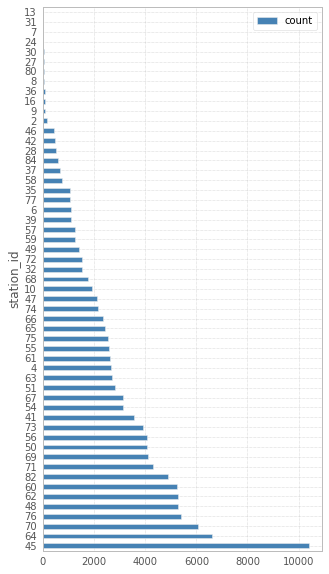

In [19]:
stations = (
    df.filter(col("bikes_available") == 0)
    .groupby("station_id")
    .count()
    .sort(desc("count"))
    .collect()
)
df_plot = pd.DataFrame(
    [(station[0], station[1]) for station in stations], columns=["station_id", "count"]
)
df_plot.plot(x="station_id", y="count", kind="barh", figsize=(5, 10), color="steelblue")

In [28]:
df2 = df.filter(F.col("bikes_available")==0).cache()
df2.count()

123468

In [30]:
df3 = df2.withColumn("Q", F.quarter(F.col("time")))
df3.groupby("Q").count().show()

+---+-----+
|  Q|count|
+---+-----+
|  1|13199|
|  3|47138|
|  2|63131|
+---+-----+

